### Calculate total population for each age group

Using the population (density) dataset and the ratio of the population for each age group to the total population for each country, we can calulate the population for each age group for each grid cell

In [1]:
import geopandas as gpd
import xarray as xr
from cartopy import crs as ccrs
#import seaborn as sns; sns.set_theme()
import os
import fiona
import country_converter as coco
import dask
import dask.array as da
import netCDF4 as nc
import regionmask
from matplotlib import cm
import numpy as np
from matplotlib import pyplot as plt
import country_converter as coco
import pyogrio
#pyogrio.set_gdal_config_options({"SHAPE_RESTORE_SHX": "YES"})
import pandas as pd
from cartopy.util import add_cyclic_point
import nc_time_axis
import glob
import cdo
import pandas as pd
import cartopy.feature as cfeature
import plotly.express as px


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# read in mortality data that has been verified

#mortality = pd.read_csv(f'./Mortality_data/IFs/mortality_all_new.csv')
#mortality per thousand
male_frac = xr.open_mfdataset(f'./demographic/countries/male_pop_by_age_frac.nc')
female_frac = xr.open_mfdataset(f'./demographic/countries/female_pop_by_age_frac.nc')

#used to make a mask
population = xr.open_dataset(f'./population/SSP2/Total/NetCDF/ssp2_2020.nc')


In [15]:
# Gridded Population of the World, Version 4 (GPWv4): National Identifier Grid, Revision 11
# can be downloaded from: https://www.earthdata.nasa.gov/data/catalog/sedac-ciesin-sedac-gpwv4-natiden-r11-4.11#:~:text=Description,use%20in%20aggregating%20population%20data.
# cited as: Center For International Earth Science Information Network-CIESIN-Columbia University. (2018). Gridded Population of the World, Version 4 (GPWv4): National Identifier Grid, Revision 11 (Version 4.11) [Data set]. Palisades, NY: NASA Socioeconomic Data and Applications Center (SEDAC). https://doi.org/10.7927/H4TD9VDP
shapefile_path = "./gpw-v4-national-identifier-grid-rev11_15_min_asc/gpw_v4_national_identifier_grid_rev11_15_min.shp"

# Read the shapefile
gdf = gpd.read_file(shapefile_path)
#gdf_list = pd.read_csv(f'/glade/u/home/cindywang625/Mortality_data/country_borders/gpw_new.csv')

In [16]:
#get country mask
lon = population['lon']
lat = population['lat']
print(lat.shape)
mask = regionmask.mask_3D_geopandas(gdf,lon,lat)

(1117,)


In [18]:
age_mapping = {
    0: '25to30',
    1: '30to35',
    2: '35to40',
    3: '40to45',
    4: '45to50',
    5: '50to55',
    6: '55to60',
    7: '60to65',
    8: '65to70',
    9: '70to75',
    10: '75to80',
    11: '80to85'
} 

age_theta = {
    '25to29': 0.1585,
    '30to34': 0.1577,
    '35to39': 0.1570,
    '40to44': 0.1558,
    '45to49': 0.1532,
    '50to54': 0.1499,
    '55to59': 0.1462,
    '60to64': 0.1421,
    '65to69': 0.1374,
    '70to74': 0.1319,
    '75to79': 0.1253,
    '80to84': 0.1141
}

region_to_iso = dict(enumerate(gdf['ISOCODE']))
# Replace the integer age coordinates in `combined` with the corresponding strings
#combined['age'] = [age_mapping[age] for age in combined.age.values]

### Multiply the original population grid with the ratio of the population for each age group to the total population for each country

In [19]:
iso_demographic = np.zeros((12))#, C.lat.shape[0],C.lon.shape[0]))

demo_grid = {}

for region, iso in region_to_iso.items():
    if iso in male_frac['region']:
        for i in range(12):
            #selected_data = demographic[list(age_theta)[i]].sel(region = f'{iso}').values
            iso_demographic[i] = male_frac[list(age_theta)[i]].sel(region = f'{iso}').values
        new = iso_demographic[:, np.newaxis, np.newaxis]
        new = np.broadcast_to(new, (12, 1117, 2880))
        demo_grid[region] = (('age', 'lat', 'lon'), population['ssp2_2020'].expand_dims(dim='age')*new*mask[region].to_numpy()[np.newaxis])
    else:
        demo_grid[region] = (('age', 'lat', 'lon'), np.full((12, 1117, 2880), 0))

In [42]:
demo_arrays = []
regions = []

for region, (dims, data) in demo_grid.items():
    # Convert each region’s array to a dask array with chunking
    #demo_arrays.append(da.from_array(data, chunks=(12, 200, 200))) 
    demo_arrays.append(np.array(data))  # Force eager evaluation
# adjust chunks
    regions.append(region)

In [ ]:
demo_pop = np.stack(demo_arrays, axis=0)
#demo_pop_dask = da.stack(demo_arrays, axis=0)


In [11]:
ds_p = xr.Dataset(
    {
        "demo_pop": (("region", "age", "lat", "lon"), demo_pop_dask)
    },
    coords={
        "region": regions,  # List of region names
        "age": np.arange(12),  # Example: 12 age groups
        "lat": population['lat'],  # Example: Latitude coordinates
        "lon": population['lon'],  # Example: Longitude coordinates
    }
)

In [12]:
combined_pop = ds_p['demo_pop'].sum(dim='region')


In [13]:
combined_pop['age'] = [list(age_theta)[age] for age in combined_pop.age.values]

In [37]:
combined_pop.to_netcdf(f'/glade/u/home/cindywang625/Mortality_data/demographic/countries/male_2020_demo_frac.nc')

ValueError: Array chunk size or shape is unknown. Possible solution with x.compute_chunk_sizes()

In [ ]:
iso_demographic = np.zeros((12))#, C.lat.shape[0],C.lon.shape[0]))

demo_grid = {}

for region, iso in region_to_iso.items():
    if iso in male_frac['region']:
        for i in range(12):
            #selected_data = demographic[list(age_theta)[i]].sel(region = f'{iso}').values
            iso_demographic[i] = female_frac[list(age_theta)[i]].sel(region = f'{iso}').values
        new = iso_demographic[:, np.newaxis, np.newaxis]
        new = np.broadcast_to(new, (12, 1117, 2880))
        demo_grid[region] = (('age', 'lat', 'lon'), population['ssp2_2020'].expand_dims(dim='age')*new*mask[region].to_numpy()[np.newaxis])
    else:
        demo_grid[region] = (('age', 'lat', 'lon'), np.full((12, 1117, 2880), 0))

demo_arrays = []
regions = []

for region, (dims, data) in demo_grid.items():
    # Convert each region’s array to a dask array with chunking
    #demo_arrays.append(da.from_array(data, chunks=(12, 200, 200))) 
    demo_arrays.append(np.array(data))  # Force eager evaluation
# adjust chunks
    regions.append(region)

demo_pop = np.stack(demo_arrays, axis=0)

ds_p = xr.Dataset(
    {
        "demo_pop": (("region", "age", "lat", "lon"), demo_pop_dask)
    },
    coords={
        "region": regions,  # List of region names
        "age": np.arange(12),  # Example: 12 age groups
        "lat": population['lat'],  # Example: Latitude coordinates
        "lon": population['lon'],  # Example: Longitude coordinates
    }
)

combined_pop = ds_p['demo_pop'].sum(dim='region')
combined_pop['age'] = [list(age_theta)[age] for age in combined_pop.age.values]
combined_pop.to_netcdf(f'/glade/u/home/cindywang625/Mortality_data/demographic/countries/female_2020_demo_frac.nc')

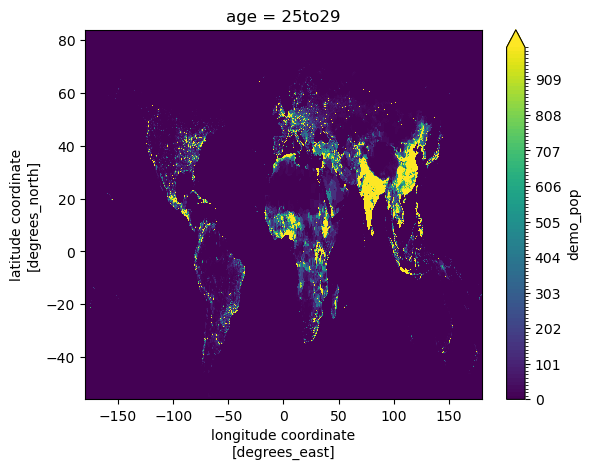

In [2]:
xr.open_mfdataset('./demographic/countries/female_2020_demo_frac.nc')['demo_pop'][0].plot(levels = np.linspace(0,1000,100))

                                                                                          

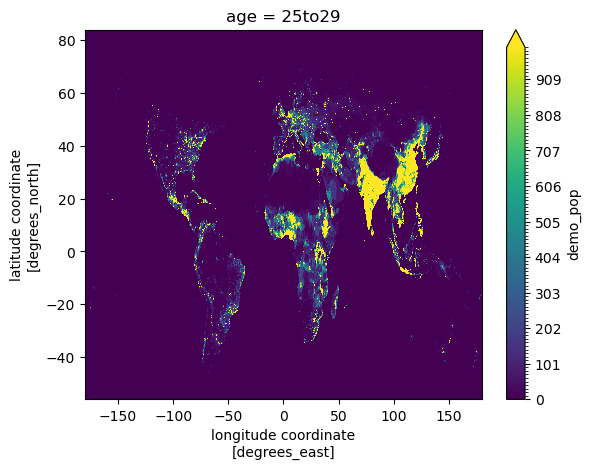

In [3]:
xr.open_mfdataset('./demographic/countries/male_2020_demo_frac.nc')['demo_pop'][0].plot(levels = np.linspace(0,1000,100))


In [8]:
xr.open_mfdataset('./demographic/countries/female_2020_demo_frac.nc')['demo_pop'].sum(("lat","lon")).plot()


array(2.35743061e+08)

In [7]:
xr.open_mfdataset('./demographic/countries/male_2020_demo_frac.nc')['demo_pop'].sum(("lat","lon")).plot()

array(2.39060318e+08)

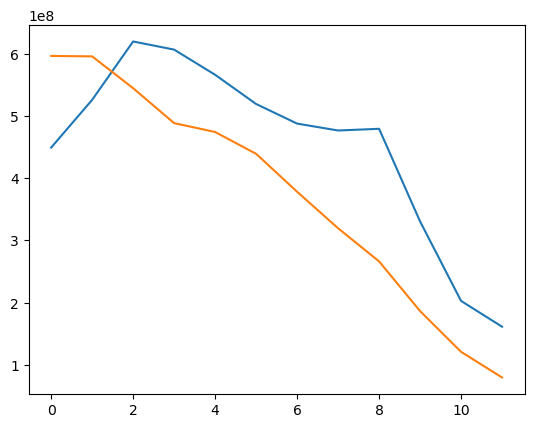

In [7]:
plt.plot(np.linspace(0,11,12),xr.open_mfdataset('./demographic/countries/2020_demo_frac.nc')['demo_pop'].sum(("lat","lon")))
plt.plot(np.linspace(0,11,12),(xr.open_mfdataset('./demographic/countries/female_2020_demo_frac.nc')['demo_pop'].sum(("lat","lon"))+
xr.open_mfdataset('./demographic/countries/male_2020_demo_frac.nc')['demo_pop'].sum(("lat","lon"))))


In [6]:
np.linspace(0,11,12)


array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.])